In this post, I'm going to continue on the same theme from the last post: [random sampling](link://slug/sampling-from-a-normal-distribution).  We're going to look at two methods for sampling a distribution: rejection sampling and Markov Chain Monte Carlo Methods (MCMC) using the Metropolis Hastings algorithm.  As usual, I'll be providing a mix of intuitive explanations, theory and some examples with code.  Hopefully, this will help explain a relatively straight-forward topic that is frequently presented in a complex way.

<!-- TEASER_END -->

## Background

Before we get into the meat of the subject, let's breakdown the term Markov Chain Monte Carlo (MCMC) into it's basic components: Monte Carlo methods and Markov chains.  With an understanding of these two, MCMC makes a whole lot more sense.

### Monte Carlo Methods

[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) is a general term for a broad class of algorithms that use random sampling to compute some numerical result.  It is often used when it is difficult or even impossible to compute things directly.  Example applications are optimization, numerical integration and sampling from a probability distribution. 

The key idea here is we're using some algorithm that uses random sampling to compute a result.  For example, if we can express the result as the expected value (read: integral) of a random variable then we can empirically compute the expected value using a bunch of independent random samples.  In the context of this post, we'll primarily be focused on methods to generate those independent random samples according to a particular distribution.  In fact, my previous post of [Sampling a Normal Distribution](link://slug/sampling-from-a-normal-distribution) is technically a Monte Carlo method (albeit a simple one).

### Markov Chains

A [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) is a "a random process that undergoes transitions from one state to another on a state space".  You can look up the formal definition on Wikipedia but informally, it's best described as a finite state machine where the transitions represent probabilities of going from one state to another.  Let's take a look at an example from Wikipedia of a [simple weather model](https://en.wikipedia.org/wiki/Examples_of_Markov_chains#A_very_simple_weather_model) (image from Wikipedia):

![simple markov chain](/images/weather_markov_chain.png)

As you can see it looks just like a finish state machine except we've annotated the state transitions with probabilities.  For example, we can see if it's sunny today, there is a \\(0.9\\) chance of being sunny tomorrow and a \\(0.1\\) chance of being rainy.  Similarly starting in rainy state.  It should be clear that from a given state, all the outgoing transitions should total \\(1.0\\) since it's a proper distribution.

Another way to represent this information is via a transition matrix \\(P\\):

\begin{align}
P = 
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}
\end{align}

The interesting thing about representing it as a matrix is that we can simulate the Markov Chain just by doing matrix multiplications.  For example, suppose we start in a sunny state, we can represent that as the row vector:  \\( {\bf x}^{(0)} = \begin{bmatrix}1 & 0\end{bmatrix}\\).  This implicitly represents that we're in the sunny state with probability \\(1\\), and thus in the rainy state with probability \\(0\\).  Now, if we perform that matrix multiplication we can find out the probabilities of being in each state after one step:

\begin{align}
{\bf x}^{(1)} = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}
= 
\begin{bmatrix}
0.9 & 0.1
\end{bmatrix}
\end{align}

We can see that that there is a \\(0.9\\) chance of being sunny tomorrow (according to our simple model), and a \\(0.1\\) chance of being rainy.   We can actually keep multiplying the transition matrix through to find the chance of sun/rain \\(k\\) steps later:

\begin{align}
{\bf x}^{(k)} = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}^k
\end{align}

We can easily compute, \\({\bf x}^{(k)}\\) for various values of \\(k\\) using `numpy`:

In [6]:
import numpy as np
from numpy import linalg as LA

def simulate_markov(x_0, P, k):
    for i in range(k):
        P_k = LA.matrix_power(P, i)
        x_k = np.dot(x_0, P_k)
        print("x^(%d) = [%.4f %.4f]" % (i, x_k[0], x_k[1]))
        
P = np.array([[0.9, 0.1], [0.5, 0.5]])
istate = np.array([1, 0])
        
simulate_markov(istate, P, 10)

x^(0) = [1.0000 0.0000]
x^(1) = [0.9000 0.1000]
x^(2) = [0.8600 0.1400]
x^(3) = [0.8440 0.1560]
x^(4) = [0.8376 0.1624]
x^(5) = [0.8350 0.1650]
x^(6) = [0.8340 0.1660]
x^(7) = [0.8336 0.1664]
x^(8) = [0.8334 0.1666]
x^(9) = [0.8334 0.1666]


We can see an interesting phenomenon here where the probability of being sunny or rainy seem to converge as we take more steps in our state machine.  You might think it has something to do with the initial state we're in but in fact, it doesn't.  We'll get the same result if we initialize the initial state to something random:

In [4]:
r = np.random.rand()
simulate_markov(np.array([r, 1 - r]), P, 10)

x^(0) = [0.3653 0.6347]
x^(1) = [0.6461 0.3539]
x^(2) = [0.7584 0.2416]
x^(3) = [0.8034 0.1966]
x^(4) = [0.8214 0.1786]
x^(5) = [0.8285 0.1715]
x^(6) = [0.8314 0.1686]
x^(7) = [0.8326 0.1674]
x^(8) = [0.8330 0.1670]
x^(9) = [0.8332 0.1668]


This steady state distribution is called a [stationary distribution](https://en.wikipedia.org/wiki/Markov_chain#Steady-state_analysis_and_limiting_distributions) usually denoted by \\({\bf \pi}\\).  This steady state vector \\(\bf \pi\\) can be found in several ways.  The most straight forward is by taking the limit as \\(n\\) approaches infinity.

\begin{align}
{\bf q} = lim_{n \rightarrow \infty} {\bf x}^{(n)}  \tag{1}
\end{align}

The next way is just by solving the equation.  Since \\(\bf q\\) by definition is the steady state, then multiplying by \\(P\\) should give the same value back:

\begin{align}
{\bf \pi}P = {\bf \pi} \\
{\bf \pi}(P - I) = {\bf 0} \tag{2}
\end{align}

where \\(I\\) is the identity matrix.  If you expand out our vector/matrix notation, you'll see that this is just a system of equations along with the additional constraint that \\(\pi_1, \pi_2, ..., \pi_n\\) all sum to \\(1\\) (i.e. \\(\pi\\) forms a probability distribution).  In our case with just two states: \\(\pi_1 + \pi_2 = 1\\).

However, not every Markov Chain has a stationary distribution or even a unique one [<sup>[1]</sup>](#fn-1).  But we can guarantee these properties if we add two additional constraints to the Markov Chain:

1. *Irreducible*: we must be able to reach any one state from any other state eventually (i.e. the expected number of steps is finite).
1. *Aperiodic*: the system never returns to the same state with a fixed period (e.g. not returning to start "sunny" deterministically every 5 steps).

Together these two properties define the property [*ergodic*](http://nlp.stanford.edu/IR-book/html/htmledition/definition-1.html).  An important theorem says that if a Markov Chain is ergodic then it has a unique steady state probability vector \\(\bf \pi\\).  In the context of MCMC, we can jump from any state to any other state (with some finite probability), trivially satisfying irreducibility.

Another useful definition we'll use is that of [detailed balance and reversible Markov Chains](https://en.wikipedia.org/wiki/Markov_chain#Reversible_Markov_chain).  A Markov Chain is said to be reversible (also known as the detailed balance condition) if there exists a probability distribution \\(\bf \pi\\) that satisfies this condition:

\begin{align}
\pi_i P(X_{n+1} = j | X_{n} = i) = \pi_j P(X_{n+1} = i | X_{n} = j)  \tag{3}
\end{align}

In other words, in the long run, the proportion of times that you transition from state \\(i\\) to state \\(j\\) is the same as the proportion of times you transition from state \\(j\\) to state \\(i\\).  In fact, if a Markov Chain is reversible then we know that it has a stationary distribution (which is why we use the same notation \\(\bf \pi\\)).  We'll need Equation 3 when we derive the Metropolis-Hastings algorithm.

### Markov Chain Monte Carlo Methods

Markov Chain Monte Carlo (MCMC) methods are simply a class of algorithms that use Markov Chains to sample from a particular probability distribution (the Monte Carlo part).  They work by creating a Markov Chain where the limiting distribution (or stationary distribution) is simply the distribution we want to sample.

Here's a picture that might help describe the process [<sup>[2]</sup>](#fn-2).  Imagine we're trying to make a MCMC to try to sample an arbitrary one dimensional distribution with PDF \\(f(x)\\).  In this case, our states would be points along the \\(x\\)-axis and our transition probabilities would be the chance of going from one state to another.  Here's a simplified figure of the situation:

![simple markov chain](/images/mcmc.png)

This figure shows the density function we're trying to approximate with the thick black line, and a visualization of part of the Markov Chain using the blue lines transitioning from orange states.  In particular, just the transitions from state \\(X_0\\) to \\(X_i\\) for  \\(i=\\{-3,-2,-1, 1, 2, 3\\}\\).  However, each point on the x-axis line is actually a potential state in this Markov Chain.  Notice that this means that we have an infinite state space, thus we can't represent the transitions nicely as a matrix anymore.  The real "trick" to MCMC methods is that we want to design the transition probabilities between states (or points on the x-axis) such that we spend most of our time in regions where \\(f(x)\\) is large, and relatively small amounts of time in regions where it is small (i.e. in the exact proportions to our density function).

In the case of our figure, we'd want to spend most of our time around the center and less time around the outside. 
In fact, if we simulate our Markov Chain long enough, the limiting distribution of states should approximate the PDF that we're trying to sample.  So the basic algorithm for sampling using a MCMC method amounts to:

1. Start at an arbitrary point \\(x\\).
2. Jump to point \\(x'\\) with a certain transition probability (this may mean staying in the same state).
3. Go to step 2 until we have transitioned \\(T\\) times.
4. Record current state \\(x'\\), go to step 2.

Now the proportionate number of times we spend at each point x-axis should be an approximation of the PDF we're trying to simulate i.e. if we plot the histogram of x-values, we should get the same shape.  Note that there is an extra step (3) that is required.  This is because when transitioning from state \\(x\\) to \\(x'\\) the points are obviously correlated (the probability of going to \\(x'\\) depends on the current state \\(x\\)).  However, when sampling we want *independent* samples.  So we basically throw away a bunch of our samples in order to ensure we get independent samples.  The value of \\(T\\) has to be picked depending on the details of our target distribution and the construction of the transition probabilities.

## Rejection Sampling

Now before we get into a concrete algorithm for MCMC methods, I want to introduce another method for sampling a probability distribution that we'll be using later called [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).  The main idea is that if we're trying to sample from a distribution \\(f(x)\\), we'll use another instrumental distribution, \\(g(x)\\), to help sample from \\(f(x)\\).  The only restriction is that \\(f(x) < Mg(x)\\) for some \\(M > 1\\).  It's primary use is when the form of \\(f(x)\\) makes it hard to sample with directly (but still possible to evaluate it at any point \\(x\\)).  

Here's a breakdown of the algorithm:

1. Sample \\(x\\) from  \\(g(x)\\).
2. Sample \\(y\\) from \\(U(0, Mg(x))\\) (uniform distribution).
3. If \\(y < f(x)\\), then accept \\(x\\) as a sample for \\(f(x)\\), otherwise go to step 1.

The reason this works is that the uniform distribution helps us "scale" the envelope provided by \\(Mg(x)\\) down to the PDF of \\(f(x)\\).  Another way to look at it is the probability that we sample a point \\(x_0\\).  This is proportional to the probability of sampling \\(x_0\\) from \\(g\\) times the proportion of times we accept, which is simply given by the ratio between \\(f(x_0)\\) and \\(Mg(x_0)\\):

\begin{align}
P(\text{sampling } x_0) \propto g(x_0) * \frac{f(x_0)}{Mg(x_0)} = \frac{f(x_0)}{M} \tag{4}
\end{align}

Equation 4 tells us the probability of sampling an arbitrary point is proportional to \\(f(x_0)\\).  After sampling many points and finding the proportion of times that we see \\(x_0\\), the constant \\(M\\) is normalized out and we get the correct result for the PDF \\(f(x)\\).

Let's take a look at it more visually with an example.  Our target distribution, \\(f(x)\\), that we want to sample from is [double gamma](http://scipy.github.io/devdocs/tutorial/stats/continuous_dgamma.html) distribution, basically a two-sided gamma distribution.  We'll be using a normal distribution, \\(g(x)\\), as our envelope distribution.  From my last post, we know how to [sample from a normal distribution](link://slug/sampling-from-a-normal-distribution) using just only a couple of uniform random variables.  The code below shows us how to find the scaling constant \\(M\\) as well as draws us a picture of how the rejection sampling conceptually works. 

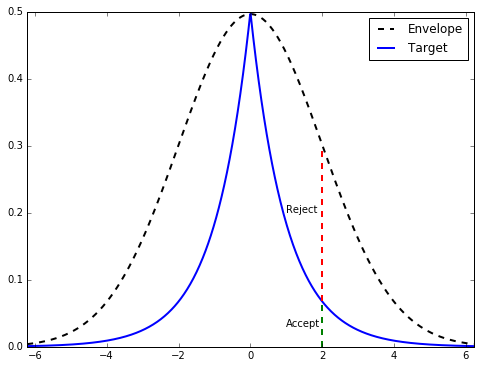

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Target = double gamma distribution
# Envelope = normal distribution 
dg = stats.dgamma(a=1)
norm = stats.norm(loc=0, scale=2)

# Generate samples for PDF
x = np.linspace(min(dg.ppf(0.001), norm.ppf(0.001)), 
                max(dg.ppf(0.999), norm.ppf(0.999)), 1000)
dg_samples = dg.pdf(x)
norm_samples = norm.pdf(x)

# Find scaling constant for envelope 
M = max(dg_samples / norm_samples)

# Plot
df = pd.DataFrame({'Target': dg_samples, 'Envelope': M * norm_samples}, index=x)
ax = df.plot(style=['--', '-'], color=['black', 'blue'], 
             figsize=(8,6), linewidth=2.0)
ax.plot((2, 2), (0, dg.pdf(2)), 'g--', linewidth=2.0)
ax.plot((2, 2), (dg.pdf(2), M * norm.pdf(2)), 'r--', linewidth=2.0)
ax.text(1.0, 0.20, 'Reject')
ax.text(1.0, 0.03, 'Accept')

From the figure, once we find a sample for \\(g(x)\\) (in this case \\(x=2\\)), we draw from a uniform distribution with range equal to the height of \\(Mg(x)\\).  If it's within the height of the target PDF, we accept it (green), otherwise reject (reject).

### Implementing Rejection Sampling

The code below implements rejection sampling for our target double gamma distribution.  It plots the scaled histogram and matches it up with the theoretical PDF we should get.

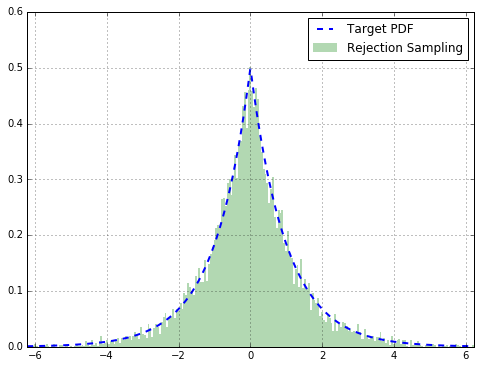

In [8]:
def rejection_sampling():
    while True:
        # Re-use global parameters from above
        x = np.random.normal(0, 2)
        envelope = M * norm.pdf(x)
        p = np.random.uniform(0, envelope)
        if p < dg.pdf(x):
            return x

# Generation samples from rejection sampling algorithm
samples = [rejection_sampling() for x in range(10000)]

# Plot Histogram vs. Target PDF
df['Target'].plot(color='blue', style='--', figsize=(8,6), linewidth=2.0)
pd.Series(samples).hist(bins=300, normed=True, color='green', 
                        alpha=0.3, linewidth=0.0)
plt.legend(['Target PDF', 'Rejection Sampling'])

Overall quite a good fit from our rejection sampler.  No doubt drawing more samples would improve the fit compared to the theoretical distribution.

The great part of rejection sampling is that it's easy to implement (just a few lines in Python) but there is a major drawback: it's slow.  You can see from the figure above, the distance between the envelope distribution and the target is quite large.  This basically amounts to "wasted" computation we need to do when computing \\(f(x)\\).  In general, it is difficult to find an efficient envelope distribution that doesn't have too much "waste".  When extending this method to higher dimensions, it becomes even more difficult because the ratio of "actual" space vs "wasted" space tends toward zero as the dimensions increase (see [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)) resulting in a highly inefficient algorithm.  Our next algorithm using an MCMC method doesn't suffer the same fate (at least not to the same extent) and uses the idea of rejection sampling as part of its algorithm.

## Metropolis-Hastings Algorithm

The [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) (MH) is an MCMC technique that draws samples from a probability distribution where direct sampling is difficult.  The restriction on MH is actually even more lax compared to rejection sampling: for a given probability density function \\(p(x)\\), we only require that we have a function \\(f(x)\\) that is *proportional* to \\(p(x)\\)!  This is extremely useful when sampling posterior distributions in [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) where the marginal likelihood (the denominator) is usually not explicitly computed.  However, MCMC methods have their drawbacks too as we shall see.

### Derivation of the Metropolis-Hastings Algorithm

To derive the Metropolis-Hastings algorithm, we first start with our end goal: creating a Markov Chain where the steady state distribution is equal to our target distribution, \\(p(x)\\).  In terms of the Markov Chain, we already know what the state space will be: the support of the probability distribution i.e. the x-values.  Thus (assuming correct construction of the Markov Chain) the steady-state distribution that we end up with will simply be \\(p(x)\\).  What's left is determining the transition probabilities between these x-values such that we can achieve this steady-state behavior.  

Recall Equation 3, the detailed balance condition for Markov Chains, written here in another way:

\begin{align}
p(x) P(x \rightarrow x') = p(x') P(x' \rightarrow x)  \tag{5}
\end{align}

Here \\(p(x)\\) is our target distribution, and \\(P(x \rightarrow x')\\) is the transition probability going from point \\(x\\) to point \\(x'\\).  So our goal is to determine the form of \\(P(x \rightarrow x')\\).  Since we get to construct the Markov Chain, let's start off by using Equation 5 as the basis for that construction.  Remember, the detailed balance condition guarantees that our Markov Chain will have a stationary distribution (that it exists).  Additionally, if we include ergodicity too (not repeating states at fixed intervals and every state much be able to reach any other state eventually), we will have built a Markov Chain that has a unique stationary distribution, \\(p(x)\\).

We can we re-arrange Equation 5 as:

\begin{align}
\frac{P(x \rightarrow x')}{P(x' \rightarrow x)} = \frac{p(x')}{p(x)} = \frac{f(x')}{f(x)} \tag{6}
\end{align}

Here we use \\(f(x)\\) to represent a function that is *proportional* to \\(p(x)\\).  This is to emphasize that we don't explicitly need \\(p(x)\\), just something proportional to it such that the ratios work out to the same thing.  Now the "trick" here is that we're going to break up \\(P(x \rightarrow x')\\) into two independent steps: a proposal distribution \\(g(x \rightarrow x')\\) and an acceptance distribution \\(A(x \rightarrow x')\\) (similar to how rejection sampling works).  Since they're independent, our transition probability is just the multiplication of the two:

\begin{align}
P(x \rightarrow x') = g(x \rightarrow x') A(x \rightarrow x') \tag{7}
\end{align}

At this point, we have to figure out what an appropriate choice for \\(g(x)\\) and \\(A(x)\\) will be.  Since \\(g(x)\\) is the "proposal distribution", it decides the next point we will potentially be sampling.  Thus, it's important that it have the same support as our target distribution \\(p(x)\\) (ergodicity condition).  A typical choice here would be the normal distribution centered on the current state.  Now given a fixed proposal distribution \\(g(x)\\), we wish to find an \\(A(x)\\) that matches.  Re-writing Equation 6 and substituting in Equation 7:

\begin{align}
\frac{A(x \rightarrow x')}{A(x' \rightarrow x)} = \frac{f(x')}{f(x)}\frac{g(x' \rightarrow x)}{g(x \rightarrow x')} \tag{8}
\end{align}

Although not obvious, a typical choice for \\(A(x)\\) that satisfies Equation 8 is:

\begin{align}
A(x \rightarrow x') = min(1, \frac{f(x')g(x' \rightarrow x)}{f(x)g(x \rightarrow x')}) \tag{9}
\end{align}

We can see that by considering the cases where \\(\frac{f(x')g(x' \rightarrow x)}{f(x)g(x \rightarrow x')}\\) is less than or equal to 1 and the cases when it is greater than 1.  When it's less than or equal to 1, it's inverse is greater than 1, thus the denominator of the LHS, \\(A(x' \rightarrow x)\\), of Equation 8 is 1, while the numerator is equal to the RHS.  Alternatively, when \\(\frac{f(x')g(x' \rightarrow x)}{f(x)g(x \rightarrow x')}\\) is greater than one the LHS numerator is 1, while the denominator is just the reciprocal of the RHS, resulting in the LHS equaling the RHS.

With that, we've shown that the steady state of the Markov Chain we've created will be equal to our target distribution (\\(p(x)\\)) because the detailed balance condition is satisfied (Equation 5) by construction.  So the overall algorithm would be (which matches closely to the MCMC algorithm above):

1. Initialize the initial state by picking a random \\(x\\).
1. Find new \\(x'\\) according to \\(g(x \rightarrow x')\\).
1. Accept \\(x'\\) with uniform probability according to \\(A(x \rightarrow x')\\).  If accepted transition to \\(x'\\), otherwise stay in state \\(x\\).
1. Go to step 2, T times.
1. Save state \\(x\\) as a sample, go to step 2 to sample another point. 

### Burn-In and Correlated Samples

Before we move on to the implementation, we need to talk about two very important topics with respect to MCMC methods.  The first topic relates to the initial state we pick.  Since we randomly pick a value for \\(x\\), it's quite possible that it is in a region where \\(p(x)\\) is quite small (think the tail ends of our double gamma distribution).  If it starts here, it might spend a disproportionate amount of time traversing through \\(x\\) values with low density, thus incorrectly giving us the sense that these \\(x\\) values should occur more often then they do.  So the solution to this is to "burn-in"  [<sup>[3]</sup>](#fn-3) the sampler by generating a bunch of samples and throwing them away.  The number of samples will depend on the specifics of the distribution we're trying to simulate.

The second problem, which we mentioned above, is the correlation between two adjacent samples.  Since by definition of our transition function \\(P(x \rightarrow x')\\), drawing \\(x'\\) is dependent on current state \\(x\\). Thus, we lose one vital property of our samples: independence.  To correct for this, we draw \\(T^{th}\\) samples, and only record the last one drawn.  Assuming \\(T\\) is large enough, the samples should be relatively independent.  Like the burn-in, the value of \\(T\\) depends on the target and proposal distribution.

### Implementing the Metropolis-Hastings Algorithm

Let's use our example from above of a double gamma distribution.  And let's define our proposal distribution as a normal distribution centered at \\(x\\) and standard deviation \\(2\\), N(x, 2) (remember \\(x\\) is given as the current state):

\begin{align}
g(x \rightarrow x') = f_{N(x,2)}(x) \tag{10}
\end{align}

Given \\(f(x)\\) proportional to our underlying distribution \\(p(x)\\) our accepting distribution looks like this:

\begin{align}
A(x \rightarrow x') = min(1, \frac{f(x')f_{N(x',2)}(x)}{f(x)f_{N(x,2)}(x')}) 
                    = min(1, \frac{f(x')}{f(x)}) \tag{11}
\end{align}

since the normal distribution is symmetric, the PDFs of the normal distributions cancel out when evaluated at their respective points. Now let's take a look at some code:

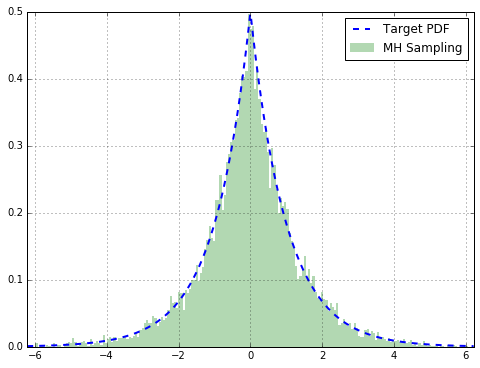

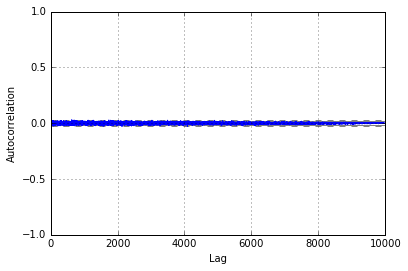

In [28]:
import math
from pandas.tools.plotting import autocorrelation_plot

# Simulate a f(x) proportional to the double gamma distribution
f = lambda x: dg.pdf(x) * math.pi

def mh_sampler(T=100):
    T=100
    x_curr = np.random.rand()
    while True:
        for i in range(T):
            x_next = np.random.normal(x_curr, 2)
            if min(1, f(x_next) / f(x_curr)) > np.random.uniform(0, 1):
                x_curr = x_next
        yield x_curr

# Burn-in
sampler = mh_sampler()
for x in range(1000):
    next(sampler)

# Sample
samples = [next(sampler) for x in range(10000)]

# Plot Histogram vs. Target PDF
df['Target'].plot(color='blue', style='--', figsize=(8,6), linewidth=2.0)
pd.Series(samples).hist(bins=300, normed=True, color='green', 
                        alpha=0.3, linewidth=0.0)
plt.legend(['Target PDF', 'MH Sampling'])
plt.show()

# Plot autocorrelation to ensure samples are independent
autocorrelation_plot(pd.Series(samples))

As we can see visually, the samples from our MH sampler are a good approximation to our double gamma distribution.  Additionally, looking at the autocorrelation plot, we can see that it's quite small across our entire sample, indicating that they are relatively independent.  If we had not picked a good value for \\(T\\) or not had a burn-in period, we would we would likely see large values in the plot.

# Conclusion

I hope you enjoyed this brief post on sampling using rejection sampling and MCMC using the Metropolis-Hastings algorithm.  When I first read about MCMC methods, I was extremely confused about how the Markov Chain was connected to sampling.  Coming from a computer engineering background, the concept of Markov Chains as a state machine with probability transitions seemed intuitive, but the connection to creating a random sampler was not.  After much thought and digging through various sources, I finally understood it in a conceptually satisfying way.  The result was this post.  I think this is going to be an on going theme for this blog: find something I don't understand (and interesting), learn it, and explain it in a way that I do understand.  What could be simpler?

## References and Further Reading


* Wikipedia: [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain), [Examples of Markov Chains](https://en.wikipedia.org/wiki/Examples_of_Markov_chains), [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)
* [Markov Chain Definitions](http://nlp.stanford.edu/IR-book/html/htmledition/definition-1.html), *Introduction to Information Retrieval*, Christopher D. Manning, Prabhakar Raghavan & Hinrich Schütze.
* [Time-reversible Markov Chains](http://www.columbia.edu/~ks20/stochastic-I/stochastic-I-Time-Reversibility.pdf) (Karl Sigman, Columbia University)
* [Rejection Sampling](https://theclevermachine.wordpress.com/2012/09/10/rejection-sampling/) (Dustin Stansbury)

## Notes

List of Notes: [^1], [^2], [^3]

[^1]: Two examples: a Markov Chain that always just stays in the state it's currently in (non-unique steady state) and a Markov Chain that deterministically alternates between two states (no steady state).

[^2]: Here I'm describing [random walk MCMC methods](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo#Random_walk_Monte_Carlo_methods).  There are other types but these are by far the most common when talking about MCMC methods especially in the context of Bayesian inference techniques.

[^3]: The term burn-in is taken from the corresponding concept where physical components (such as electronics) are exercised prior to being put in production in order to sort out any of the potentially flawed components.  See: https://en.wikipedia.org/wiki/Burn-in